In [1]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import tensorflow.keras as keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

In [2]:
train_normal = pd.read_csv("train_normal.csv")
train_fraud = pd.read_csv("train_fraud.csv")
test_normal = pd.read_csv("test_normal.csv")
test_fraud = pd.read_csv("test_fraud.csv")

preprocessor = joblib.load('pipeline.pkl')
preprocessor

Pipeline(memory=Memory(location=C:\Users\ADMIN\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['amt', 'lat', 'long', 'dob',
                                             'unix_time', 'merch_lat',
                                             'merch_long'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=['category', 'gender'],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                (...
                                    transformer=OrdinalEncoder(cols=['gender'],
                                                               handle_missing='return_nan',
                                                               mapping=[{'col': 'gender',
                                                                         'data_type': dtype('O'),
                                                                         'mapping': F      0
M      1
NaN   -1
dtype: int64}]))),
                ('onehot_encoding',
                 TransformerWrapper(include=['category'],
                                    transformer=OneHotEncoder(cols=['category'],
                                                              handle_missing='return_nan',
                                                              use_cat_names=True))),
                ('normalize',
                 TransformerWrapper(transformer=StandardScaler()))])

In [3]:
train_normal = preprocessor.transform(train_normal)
train_fraud = preprocessor.transform(train_fraud)
test_normal = preprocessor.transform(test_normal)
test_fraud = preprocessor.transform(test_fraud)

In [4]:
train_columns = train_normal.columns[:-1]
train_columns

Index(['category_misc_net', 'category_grocery_pos', 'category_gas_transport',
       'category_entertainment', 'category_misc_pos', 'category_shopping_net',
       'category_grocery_net', 'category_shopping_pos', 'category_travel',
       'category_food_dining', 'category_health_fitness', 'category_kids_pets',
       'category_home', 'category_personal_care', 'amt', 'gender', 'lat',
       'long', 'dob', 'unix_time', 'merch_lat', 'merch_long'],
      dtype='object')

In [174]:
class AutoencoderClassification(keras.Model):
    def __init__(self):
        super(AutoencoderClassification, self).__init__()

        self.encoder = keras.models.Sequential([
            keras.layers.Dense(32, activation='relu'),
            keras.layers.Dense(16, activation='relu'),
            keras.layers.Dense(8, activation='relu'),
            keras.layers.Dense(8, activation='relu'),
            keras.layers.Dense(5, activation='relu'),
        ])

        self.decoder = keras.models.Sequential([
            # keras.layers.Dense(4, activation='relu'),
            keras.layers.Dense(8, activation='relu'),
            keras.layers.Dense(8, activation='relu'),
            keras.layers.Dense(16, activation='relu'),
            keras.layers.Dense(32, activation='relu'),
            keras.layers.Dense(len(train_columns), activation='linear')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    

autoencoder = AutoencoderClassification()
autoencoder.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [175]:
hist = autoencoder.fit(train_normal[train_columns], train_normal[train_columns], 
                       epochs=30, validation_split=0.02, batch_size=4096, 
                       callbacks=keras.callbacks.EarlyStopping(patience=3)
                       )

Epoch 1/30
309/309 [==============================] - 3s 6ms/step - loss: 0.7268 - mae: 0.5305 - val_loss: 0.5308 - val_mae: 0.4779
Epoch 2/30
309/309 [==============================] - 2s 5ms/step - loss: 0.3062 - mae: 0.3549 - val_loss: 0.3292 - val_mae: 0.3431
Epoch 3/30
309/309 [==============================] - 2s 5ms/step - loss: 0.2000 - mae: 0.2658 - val_loss: 0.2692 - val_mae: 0.2744
Epoch 4/30
309/309 [==============================] - 2s 5ms/step - loss: 0.1635 - mae: 0.2125 - val_loss: 0.2564 - val_mae: 0.2436
Epoch 5/30
309/309 [==============================] - 2s 5ms/step - loss: 0.1563 - mae: 0.1971 - val_loss: 0.2519 - val_mae: 0.2375
Epoch 6/30
309/309 [==============================] - 2s 5ms/step - loss: 0.1528 - mae: 0.1919 - val_loss: 0.2486 - val_mae: 0.2335
Epoch 7/30
309/309 [==============================] - 2s 5ms/step - loss: 0.1498 - mae: 0.1905 - val_loss: 0.2383 - val_mae: 0.2332
Epoch 8/30
309/309 [==============================] - 2s 5ms/step - loss: 0.

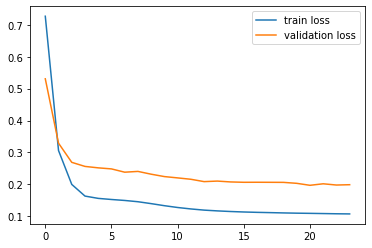

In [176]:
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

In [177]:
autoencoder.evaluate(train_fraud[train_columns], train_fraud[train_columns], batch_size=2048)

4/4 [==============================] - 0s 2ms/step - loss: 0.7950 - mae: 0.4126


[0.7950241565704346, 0.41258153319358826]

In [180]:
normal_train_reconstruction = autoencoder.predict(train_normal[train_columns], batch_size=4096)
normal_train_loss = pd.DataFrame(keras.losses.mae(normal_train_reconstruction, train_normal[train_columns]).numpy(), columns=['normal_loss'])

fraud_train_reconstruction = autoencoder.predict(train_fraud[train_columns], batch_size=4096)
fraud_train_loss = pd.DataFrame(keras.losses.mae(fraud_train_reconstruction, train_fraud[train_columns]).numpy(), columns=['fraud_loss'])

pd.concat([normal_train_loss.describe().T, fraud_train_loss.describe().T])

2/2 [==============================] - 0s 5ms/step


,count,mean,std,min,25%,50%,75%,max
normal_loss,1289169.0,0.156841,0.055565,0.056363,0.124124,0.149662,0.177451,2.035246
fraud_loss,7506.0,0.412582,0.262417,0.080868,0.184745,0.320133,0.635545,1.565316


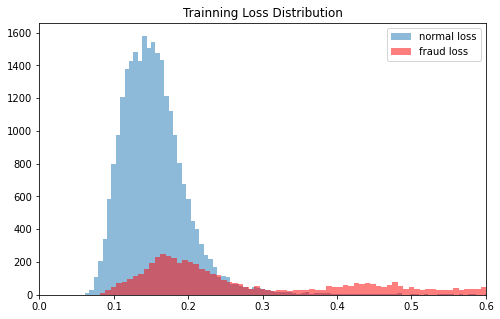

In [181]:
plt.figure(figsize=(8,5))
plt.xlim((0,0.6))
plt.hist(normal_train_loss.sample(frac=0.02, random_state=1), alpha=0.5, bins=200, label='normal loss')
plt.hist(fraud_train_loss, alpha=0.5, color='red', bins=200, label='fraud loss')
# plt.axvline(0.05)
plt.title("Trainning Loss Distribution")
plt.legend()
plt.show()

In [13]:
for layer in autoencoder.encoder.layers:
    layer.trainable=False

for layer in autoencoder.decoder.layers:
    layer.trainable=False

In [183]:
import numpy as np
from sklearn.metrics import classification_report

x = np.concatenate([normal_train_loss.to_numpy(), fraud_train_loss.to_numpy()])
y = np.concatenate([train_normal['is_fraud'], train_fraud['is_fraud']])

for threshold in np.linspace(0.3, 0.45, num=25):
    y_pred = x>threshold
    print(f"THRESHOLD = {threshold}")
    print(classification_report(y, y_pred))




THRESHOLD = 0.3
              precision    recall  f1-score   support

           0       1.00      0.98      0.99   1289169
           1       0.16      0.51      0.24      7506

    accuracy                           0.98   1296675
   macro avg       0.58      0.75      0.62   1296675
weighted avg       0.99      0.98      0.99   1296675

THRESHOLD = 0.30624999999999997
              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1289169
           1       0.17      0.51      0.25      7506

    accuracy                           0.98   1296675
   macro avg       0.58      0.75      0.62   1296675
weighted avg       0.99      0.98      0.99   1296675

THRESHOLD = 0.3125
              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1289169
           1       0.18      0.50      0.26      7506

    accuracy                           0.98   1296675
   macro avg       0.59      0.74      0.63   1296675
weighte

In [ ]:
THRESHOLD = 0.4125

autoencoder.save('autoencoder')

In [ ]:
normal_test_reconstruction = autoencoder.predict(test_normal[train_columns], batch_size=4096)
normal_test_loss = pd.DataFrame(keras.losses.mae(normal_test_reconstruction, test_normal[train_columns]).numpy(), columns=['normal_loss'])

fraud_test_reconstruction = autoencoder.predict(test_fraud[train_columns], batch_size=4096)
fraud_test_loss = pd.DataFrame(keras.losses.mae(fraud_test_reconstruction, test_fraud[train_columns]).numpy(), columns=['fraud_loss'])

pd.concat([normal_test_loss.describe().T, fraud_test_loss.describe().T])

In [ ]:
plt.figure(figsize=(8,5))
plt.xlim((0,1))
plt.hist(normal_test_loss.sample(frac=0.02, random_state=1), alpha=0.5, bins=200, label='normal loss')
plt.hist(fraud_test_loss, alpha=0.5, color='red', bins=200, label='fraud loss')
plt.axvline(THRESHOLD)
plt.title("Testing Loss Distribution")
plt.legend()
plt.show()

In [ ]:
x_test = np.concatenate([normal_test_loss.to_numpy(), fraud_test_loss.to_numpy()])
y_test = np.concatenate([test_normal['is_fraud'], test_fraud['is_fraud']])

y_pred = x_test > THRESHOLD
print(classification_report(y_test, y_pred))